## Importing Libraries

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Loading Images

In [15]:
left_img = cv.imread('res08.png').astype(np.float32)
right_img = cv.imread('res09.png').astype(np.float32)

In [16]:
print(left_img.shape, right_img.shape)

(398, 268, 3) (398, 268, 3)


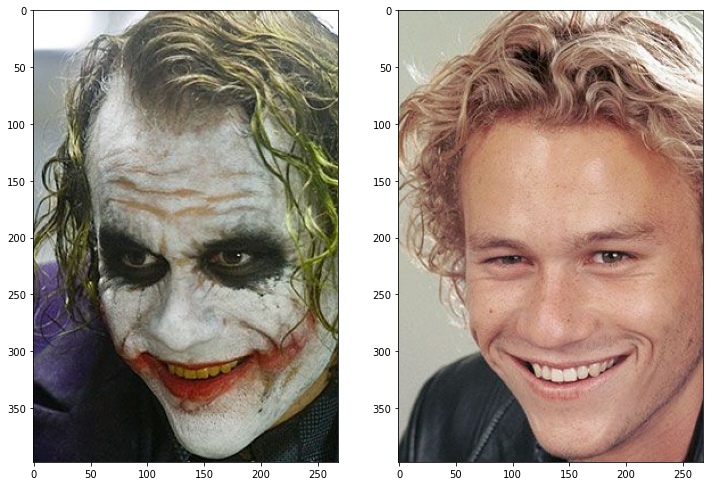

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(cv.cvtColor(left_img.astype(np.uint8), cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(right_img.astype(np.uint8), cv.COLOR_BGR2RGB));

## Without Blending

If we just copied each half and concatinated them together, we wouldn't get our desired image

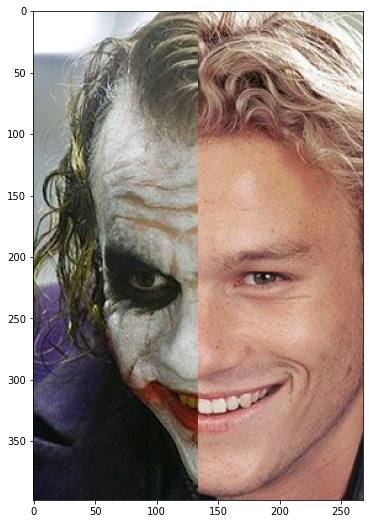

In [18]:
tmp = np.zeros_like(left_img)
half_W = left_img.shape[1]//2
tmp[:, :half_W] = left_img[:, :half_W]
tmp[:, half_W:] = right_img[:, half_W:]

plt.figure(figsize=(9, 9))
plt.imshow(cv.cvtColor(tmp.astype(np.uint8), cv.COLOR_BGR2RGB));

## Multiresolution Blending and Feathering

In this method we start by creating the Laplacian Stack (or Laplacian Pyramid) for both images. For building the laplacian stack for an image, at each level we blur the image using a gaussian filter and subtract it from the image and we push it to the stack. At the lowest level of the stack, we just simply push the image into the stack (rather than the subtracted one). Now we need to blend two images at different frequencies. For lower frequencies, we do the feathering stronger (smoother mask - stronger mask), and for the higher frequencies, we do it weaker (smaller mask). This will result in an image that the details of each images are preserved but the generality of the images are combined. 

This function creates a mask (left to right) for feathering

In [2]:
def create_feathering_mask(shape, smoothing_width):
    mask = np.zeros(shape, dtype=np.float32)
    mask[:, :shape[1]//2] = 1
    mask = cv.blur(mask, (smoothing_width, smoothing_width))
    return mask

You can see an example below

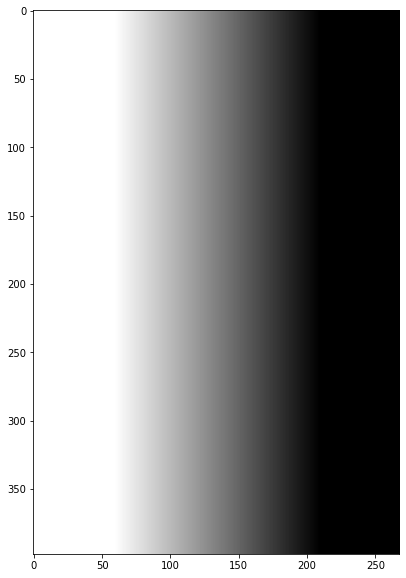

In [20]:
test_mask = create_feathering_mask(left_img.shape[:2], 150)
plt.figure(figsize=(10, 10))
plt.imshow(test_mask, cmap='gray');

This function will build the laplacian stack for us using the method described earlier. Each level, `blurred_img` is calculated using `cv.GaussianBlur` on image and then we get `laplacian_img` from `img - blurred_img`

In [3]:
def get_laplacian_stack(img, depth, gauss_kernel_size=(5, 5)):
    if depth == 1:
        return [img]
    blurred_img = cv.GaussianBlur(img, gauss_kernel_size, cv.BORDER_DEFAULT)
    laplacian_img = img - blurred_img
    return get_laplacian_stack(blurred_img, depth-1, gauss_kernel_size) + [laplacian_img]

Laplacian Stack for the left image

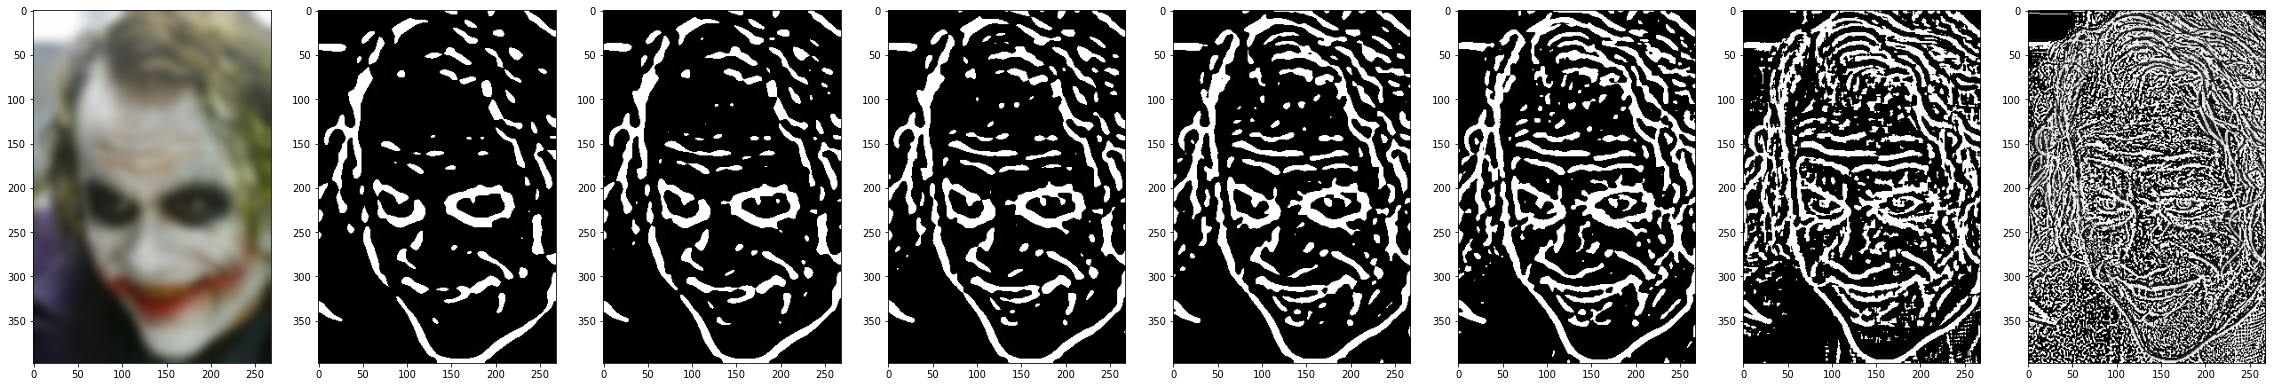

In [22]:
depth = 8
left_laplacian_stack = get_laplacian_stack(left_img, depth, (7, 7))

fig, axs = plt.subplots(1, depth, figsize=(5*depth, 10))
for i in range(depth):
    if i != 0:
        axs[i].imshow(left_laplacian_stack[i].mean(axis=2).astype(np.uint8), cmap='gray')
    else:
        axs[i].imshow(cv.cvtColor(left_laplacian_stack[i].astype(np.uint8), cv.COLOR_BGR2RGB))

Laplacian Stack for the right image

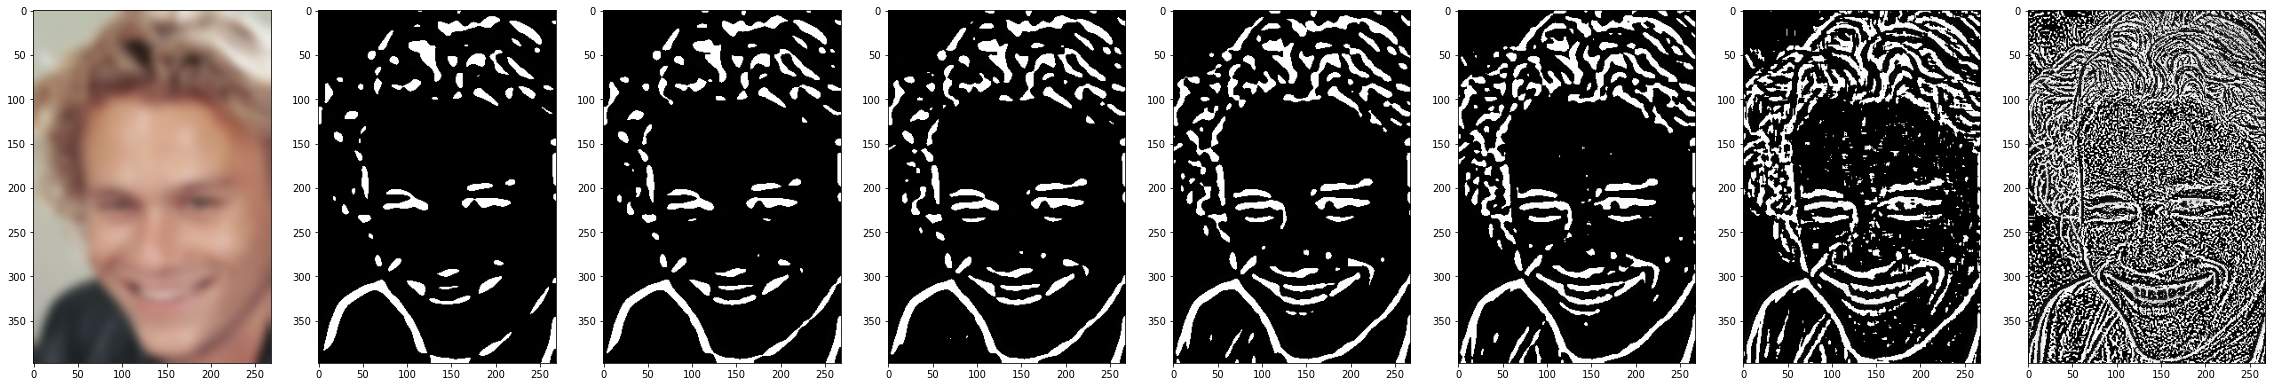

In [23]:
right_laplacian_stack = get_laplacian_stack(right_img, depth, (7, 7))

fig, axs = plt.subplots(1, depth, figsize=(5*depth, 10))
for i in range(depth):
    if i != 0:
        axs[i].imshow(right_laplacian_stack[i].mean(axis=2).astype(np.uint8), cmap='gray')
    else:
        axs[i].imshow(cv.cvtColor(right_laplacian_stack[i].astype(np.uint8), cv.COLOR_BGR2RGB))

Now, we do the feathering at each level and sum them up to get our final result. In  lower levels of the stack we use bigger masks and as we go further, we make these masks smaller (You can see the sizes of the masks in `smoothing_size_arr`). 

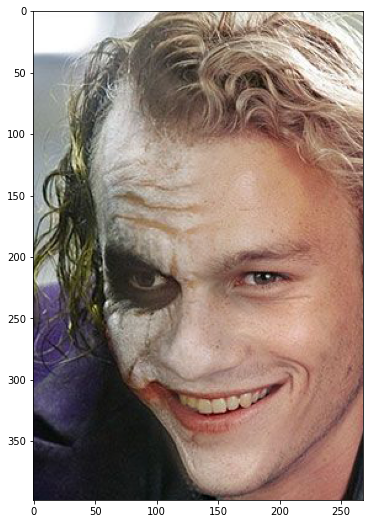

In [24]:
result = np.zeros_like(left_img, dtype=np.float32)

smoothing_size_arr = [150, 100, 90, 80, 60, 40, 20, 10]
for i in range(depth):
    mask = create_feathering_mask(left_img.shape[:2], smoothing_size_arr[i])
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    result += mask*left_laplacian_stack[i] + (1-mask)*right_laplacian_stack[i]

plt.figure(figsize=(9, 9))
plt.imshow(cv.cvtColor(result.clip(0, 255).astype(np.uint8), cv.COLOR_BGR2RGB));

You can compare the result below

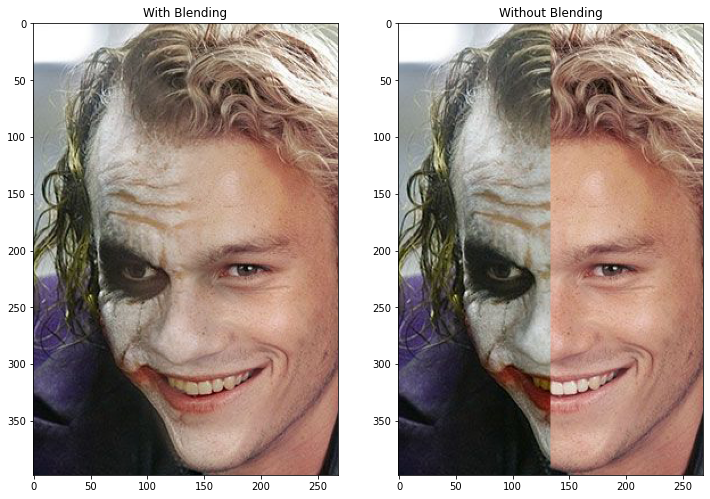

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 9))
for i, (img, title) in enumerate(zip([result, tmp], ["With Blending", "Without Blending"])):
    axs[i].imshow(cv.cvtColor(img.clip(0, 255).astype(np.uint8), cv.COLOR_BGR2RGB))
    axs[i].set_title(title)

Now let's try this method on other images

## Example 2

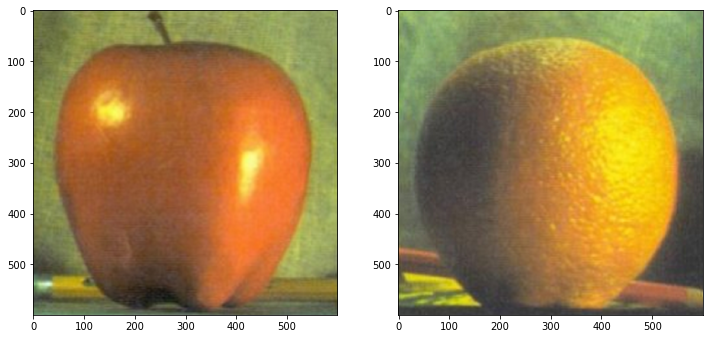

In [4]:
left_img = cv.imread('res09_another.png').astype(np.float32)
right_img = cv.imread('res08_another.png').astype(np.float32)

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(cv.cvtColor(left_img.astype(np.uint8), cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(right_img.astype(np.uint8), cv.COLOR_BGR2RGB));

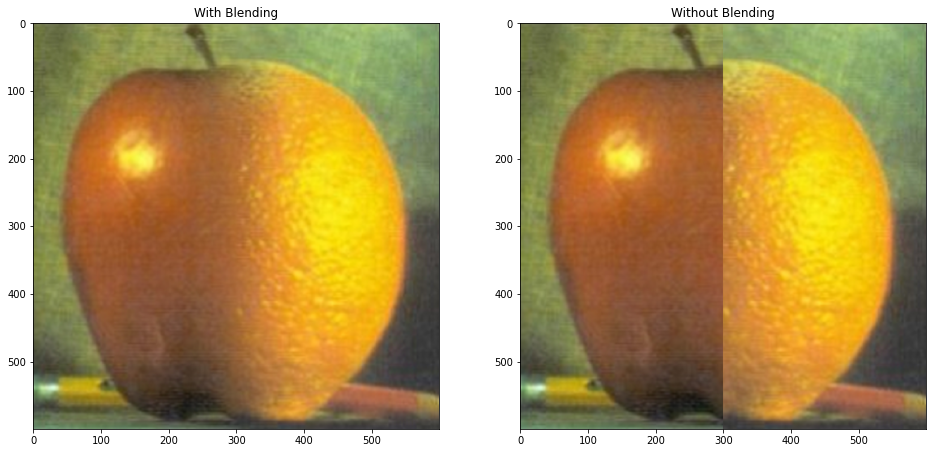

In [5]:
depth = 8
left_laplacian_stack = get_laplacian_stack(left_img, depth, (7, 7))
right_laplacian_stack = get_laplacian_stack(right_img, depth, (7, 7))

# With Blending
result = np.zeros_like(left_img, dtype=np.float32)
smoothing_size_arr = [150, 100, 90, 80, 60, 40, 20, 10]
for i in range(depth):
    mask = create_feathering_mask(left_img.shape[:2], smoothing_size_arr[i])
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    result += mask*left_laplacian_stack[i] + (1-mask)*right_laplacian_stack[i]

# Without Blending
tmp = np.zeros_like(left_img)
half_W = left_img.shape[1]//2
tmp[:, :half_W] = left_img[:, :half_W]
tmp[:, half_W:] = right_img[:, half_W:]


fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for i, (img, title) in enumerate(zip([result, tmp], ["With Blending", "Without Blending"])):
    axs[i].imshow(cv.cvtColor(img.clip(0, 255).astype(np.uint8), cv.COLOR_BGR2RGB))
    axs[i].set_title(title)

## Example 3

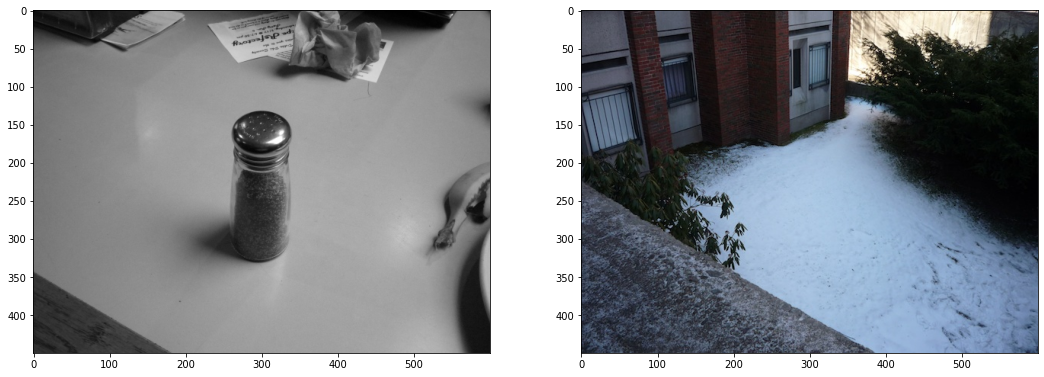

In [36]:
source_img = cv.imread('res05.jpg').astype(np.float32)
dest_img = cv.imread('res06.jpg').astype(np.float32)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
axs[0].imshow(cv.cvtColor(source_img.astype(np.uint8), cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(dest_img.astype(np.uint8), cv.COLOR_BGR2RGB));

In [37]:
source_mask = np.load('q2-source_mask.npy')
dest_mask = np.load('q2-dest_mask.npy')

# Shift source image to the place we want to put it in destination
diff_mask = np.int16(np.mean(np.array(np.where(dest_mask)).T, axis=0) - np.mean(np.array(np.where(source_mask)).T, axis=0))
M = np.float32([
    [1, 0, diff_mask[0]],
    [0, 1, diff_mask[1]]
])
source_img = cv.warpAffine(source_img, M, source_img.shape[:2][::-1])

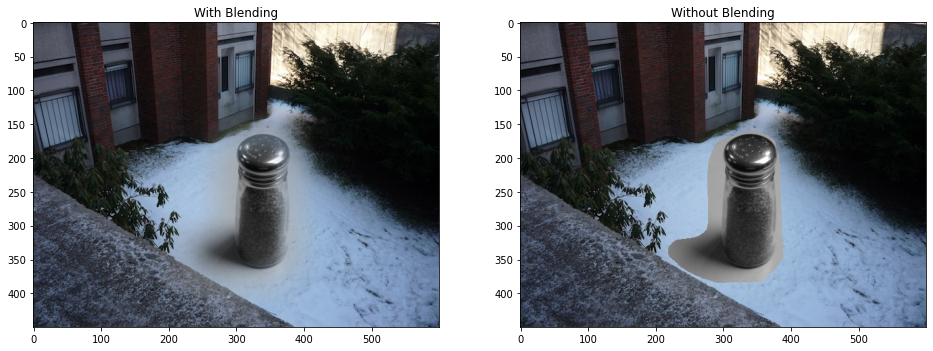

In [38]:
# With Blending
depth = 10
source_laplacian_stack = get_laplacian_stack(source_img, depth, (7, 7))
dest_laplacian_stack = get_laplacian_stack(dest_img, depth, (7, 7))

result = np.zeros_like(dest_img, dtype=np.float32)

smoothing_size = 70
alpha = 0.99
for i in range(depth):
    mask = cv.blur(dest_mask.astype(np.float32), (smoothing_size, smoothing_size))
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    
    result += mask*source_laplacian_stack[i] + (1-mask)*dest_laplacian_stack[i]
    
    smoothing_size = int(alpha * smoothing_size)


# Without Blending    
tmp_dest = dest_img.copy()
tmp_dest[dest_mask] = source_img[dest_mask]


fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for i, (img, title) in enumerate(zip([result, tmp_dest], ["With Blending", "Without Blending"])):
    axs[i].imshow(cv.cvtColor(img.clip(0, 255).astype(np.uint8), cv.COLOR_BGR2RGB))
    axs[i].set_title(title)